# XGBoost Training

## Bandgap Dataset

## Part 1: With our processed data

In [1]:
# imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import xgboost as xgb

from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from xgboost import XGBRegressor

from sklearn.model_selection import KFold

%matplotlib inline

/Users/alisonrhoads/opt/anaconda3/lib/python3.9/site-packages/pandas/core/computation/expressions.py:21: UserWarning: Pandas requires version '2.8.4' or newer of 'numexpr' (version '2.8.3' currently installed).
  from pandas.core.computation.check import NUMEXPR_INSTALLED
/Users/alisonrhoads/opt/anaconda3/lib/python3.9/site-packages/pandas/core/arrays/masked.py:61: UserWarning: Pandas requires version '1.3.6' or newer of 'bottleneck' (version '1.3.5' currently installed).
  from pandas.core import (


I am training the XGBoost model on the normalized bandgap dataset `x_y_bandgap_normalized.csv`

MinMaxScaling was used to normalized the data

The dataset contains:
- 1053 materials
- 36 normalized features (X)
- 1 normalized target column (band gap)

In [2]:
# data check
import pandas as pd
data = pd.read_csv('../processed_data/x_y_bandgap_normalized.csv')

#data.head()
#data.info()

# split data into features (X) and targets (Y)
X = data.drop(columns=['band_gap'])
Y = data['band_gap']

Next, create the training, validation and test sets. We follow the protocall in the original paper: 

*A total of 15% of the data in the original dataset was reserved as the test set, and the remaining data were divided into the training set and the validation set at a ratio of 0.85:0.15.*

Therefore:
- Test set: Randomly selected 15% of the data set

For the remaining 85% of the data set:
- Validation set: 15% 
- Training set: 85%

In [3]:
X_trainval, X_test, Y_trainval, Y_test = train_test_split(X, Y, test_size=0.15, random_state=42)

X_train, X_val, Y_train, Y_val = train_test_split(X_trainval, Y_trainval, test_size = 0.15, random_state=42)

Apply XGBRegressor to wrap the pandas data into DMatrix

See documentation here:
https://xgboost.readthedocs.io/en/stable/python/python_api.html#xgboost.XGBRegressor
        
        
Recall the following parameters from the course notes:

    Booster parameters
    param["eta"] = 0.1  # learning rate
    param["max_depth"] = 10  # maximum depth of a tree
    param["subsample"] = 0.8  # fraction of events to train tree on
    param["colsample_bytree"] = 0.8  # fraction of features to train tree on

    Learning task parameters
    param["objective"] = "binary:logistic"  # objective function
    param["eval_metric"] = "error"  # evaluation metric for cross validation, note: last one is used for early stopping
    param = list(param.items())

    num_trees = 100  # number of trees to make`
    
    
For the following implementation, we use the parameters in the paper (*Table S3*):

- Learning Rate: 0.1
- Gamma: 0
- Colsample bytree: 0.8
- Max Depth: 6
- Number Estimators: 300
- reg_alpha: 0
- reg_lambda: 1
- subsample = 1



In [4]:
kf = KFold(n_splits=10, shuffle=True, random_state=42)

r2s = []
maes = []
rmses = []

print("Fold |   R2    |   MAE   |   RMSE")
print("----------------------------------")

fold = 1

for train_idx, val_idx in kf.split(X):
    X_train_cv = X.iloc[train_idx]
    Y_train_cv = Y.iloc[train_idx]
    X_val_cv = X.iloc[val_idx]
    Y_val_cv = Y.iloc[val_idx]
    
    # Apply same parameters as in part 1:
    
    model_cv = XGBRegressor(
        n_estimators = 300,
        learning_rate = 0.1, 
        gamma = 0,
        max_depth = 6,    
        subsample = 1,   
        colsample_bytree=0.8,
        reg_alpha = 0,
        reg_lambda = 1,

        objective='reg:squarederror',
        random_state=42,
        n_jobs=-1,
    )


    model_cv.fit(X_train_cv, Y_train_cv)
    Y_pred_cv = model_cv.predict(X_val_cv)
    
    r2 = r2_score(Y_val_cv, Y_pred_cv)
    r2s.append(r2)
    mae = mean_absolute_error(Y_val_cv, Y_pred_cv)
    maes.append(mae)
    rmse = mean_squared_error(Y_val_cv, Y_pred_cv, squared=False)
    rmses.append(rmse)
    
    print(f"{fold:>4} | {r2:6.3f}  | {mae:7.3f} | {rmse:7.3f}")
    fold += 1
    
print("\nAverages over 10 folds:")
print(f"R^2   mean = {np.mean(r2s):.3f}, std = {np.std(r2s):.3f}")
print(f"MAE  mean = {np.mean(maes):.3f}, std = {np.std(maes):.3f}")
print(f"RMSE mean = {np.mean(rmses):.3f}, std = {np.std(rmses):.3f}")


model = XGBRegressor(
    n_estimators = 300,
    learning_rate = 0.1, 
    gamma = 0,
    max_depth = 6,    
    subsample = 1,   
    colsample_bytree=0.8,
    reg_alpha = 0,
    reg_lambda = 1,
    
    objective='reg:squarederror',
    random_state=42,
    n_jobs=-1,
)

model.fit(X_train, Y_train)


Fold |   R2    |   MAE   |   RMSE
----------------------------------
   1 |  0.904  |   0.399 |   0.632
   2 |  0.777  |   0.512 |   0.797
   3 |  0.883  |   0.430 |   0.624
   4 |  0.788  |   0.516 |   0.801
   5 |  0.871  |   0.392 |   0.608
   6 |  0.859  |   0.443 |   0.678
   7 |  0.737  |   0.513 |   0.813
   8 |  0.883  |   0.417 |   0.637
   9 |  0.799  |   0.524 |   0.857
  10 |  0.865  |   0.443 |   0.724

Averages over 10 folds:
R^2   mean = 0.837, std = 0.053
MAE  mean = 0.459, std = 0.049
RMSE mean = 0.717, std = 0.088


XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=0.8, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=0, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.1, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=6, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=300, n_jobs=-1,
             num_parallel_tree=None, random_state=42, ...)

In [5]:
def evaluate(model, X, Y, name):
    predictions = model.predict(X)
    mae = mean_absolute_error(Y, predictions)
    rmse = mean_squared_error(Y, predictions, squared = False)
    r2 = r2_score(Y, predictions)
    
    print(f'{name}: MAE = {mae:0.3f}, RMSE = {rmse:.3f}, R^2 = {r2:.3f}')

In [6]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

def plot_cor(Y_train, Y_train_pred,
             Y_val,   Y_val_pred,
             Y_test,  Y_test_pred,
             save_path,
             target_name="bandgap",
             model_name="XGBoost"):


    if target_name.lower() in ["bandgap", "band gap"]:
        axis_label = "Band Gap (eV)"
    elif target_name.lower() in ["formation energy", "formation_energy", "fe"]:
        axis_label = "Formation Energy (eV/atom)"
    else:
        axis_label = target_name

    fig, ax = plt.subplots(figsize=(5, 5))

    ax.scatter(Y_train, Y_train_pred,
               label='Train', alpha=0.4, color='blue')

    ax.scatter(Y_val, Y_val_pred,
               label='Validation', alpha=0.8, color='orange')

    all_true = np.concatenate([Y_train.values, Y_val.values, Y_test.values])
    low = all_true.min()
    high = all_true.max()

    ax.plot([low, high], [low, high],
            '--', color='red', label='Perfect prediction')

    ax.set_xlabel(f"True {axis_label}")
    ax.set_ylabel(f"Predicted {axis_label}")
    ax.set_title(f"{model_name} Predictions vs True Values")
    ax.legend(loc='lower right')
    ax.grid(True)

    rmse_val = mean_squared_error(Y_val, Y_val_pred, squared=False)
    r2_val   = r2_score(Y_val, Y_val_pred)
    mae_val  = mean_absolute_error(Y_val, Y_val_pred)

    textstr = (
        f'Validation R²:  {r2_val:.4f}\n'
        f'Validation MAE: {mae_val:.4f}\n'
        f'Validation MSE:{rmse_val:.4f}'
    )

    props = dict(boxstyle='round', facecolor='wheat', alpha=0.8)
    ax.text(0.05, 0.95, textstr,
            transform=ax.transAxes,
            fontsize=11,
            verticalalignment='top',
            bbox=props,
            family='monospace')

    plt.tight_layout()
    plt.savefig(save_path, dpi=600, bbox_inches="tight")
    print(f"Plot saved to: {save_path}")
    plt.show()

Next, train separate model for the training, validation and test from the original 15% split

==== XGBoost (36 features) ====
Train (Bandgap): MAE=0.029, RMSE=0.042, R^2=0.999
Val (Bandgap): MAE=0.483, RMSE=0.743, R^2=0.824
Test (Bandgap): MAE=0.476, RMSE=0.747, R^2=0.854
Plot saved to: XG_BG_36_cor.png


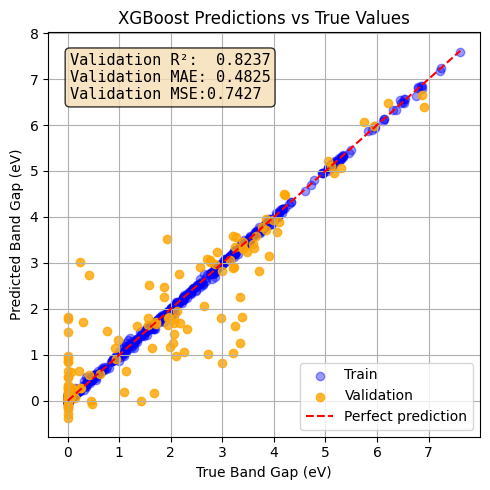

In [7]:
Y_train_pred = model.predict(X_train)
Y_val_pred   = model.predict(X_val)
Y_test_pred  = model.predict(X_test)

def evaluate(name, y_true, y_pred, target_name):
    from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
    mae = mean_absolute_error(y_true, y_pred)
    rmse = mean_squared_error(y_true, y_pred, squared=False)
    r2 = r2_score(y_true, y_pred)
    print(f"{name} ({target_name}): MAE={mae:.3f}, RMSE={rmse:.3f}, R^2={r2:.3f}")

print("==== XGBoost (36 features) ====")
evaluate("Train", Y_train, Y_train_pred, "Bandgap")
evaluate("Val",   Y_val,   Y_val_pred,   "Bandgap")
evaluate("Test",  Y_test,  Y_test_pred,  "Bandgap")


plot_cor(
    Y_train, Y_train_pred,
    Y_val,   Y_val_pred,
    Y_test,  Y_test_pred,
    save_path="XG_BG_36_cor.png",
    target_name="band gap", model_name="XGBoost"
)

## Part 2: Train on 23 features from paper

    In the bandgap prediction, a total of 23 relevant features, 
    namely the 
    
    1. electronegativity of the A-site atom, 
    2. B′-site atom
    3. B″-site atom (χ_A, χ_B′ and χ_B″)
    4. atomic mass of the A-site
    5. B′-site elements (M_A and M_B′), 
    6. electronic affinity of the A-site
    7. X-site elements (EA_A and EA_X), 
    8. atomic number of the B″-site element (Z_B″)
    9. first ionization energy of the A-site
    10. B′-site
    11. B″-site
    12. X-site elements (IE1_A, IE1_B′, IE1_B″ and IE1_X)
    13. second ionization energy of the A-site
    14. B′-site elements (IE2_A and IE2_B′)
    15. melting-point temperature of the A-site, 
    16. B′-site
    17. B″-site
    18. X-site elements (Tm_A, Tm_B′, Tm_B″ and Tm_X)
    19. boiling-point temperature of the A-site
    20. B′-site elements (Tb_A and Tb_B′), 
    21. van der Waals radius of the A-site element (Rv_A)
    22. third ionization energy of the B′-site
    23. B″-site elements (IE3_B′ and IE3_B″) 

    were finally retained, and the Pearson correlation diagram of these features was drawn, as shown in Figure 1a.

In [8]:
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from xgboost import XGBRegressor
import pandas as pd

paper_features = [
    "A_electronegativity",          
    "B1_electronegativity",        
    "B2_electronegativity",        
    "A_atomic_mass",               
    "B1_atomic_mass",              
    "A_electron_affinity",         
    "X_electron_affinity",         
    "B2_atomic_number",            
    "A_first_ionization_energy",    
    "B1_first_ionization_energy",   
    "B2_first_ionization_energy",   
    "X_first_ionization_energy",    
    "A_second_ionization_energy",   
    "B1_second_ionization_energy",  
    "A_melting_point",              
    "B1_melting_point",             
    "B2_melting_point",             
    "X_melting_point",              
    "A_boiling_point",              
    "B1_boiling_point",             
    "A_van_der_waals_radius",       
    "B1_third_ionization_energy",   
    "B2_third_ionization_energy",   
]

raw = pd.read_excel("/Users/alisonrhoads/Downloads/supplementary_data_and_dataset_3/data_set_1053.xlsx")

X_raw = raw[paper_features]
Y = raw["band_gap"]

scaler = MinMaxScaler()
X = pd.DataFrame(scaler.fit_transform(X_raw), columns=paper_features)

X_trainval, X_test, Y_trainval, Y_test = train_test_split(
    X, Y, test_size=0.15, random_state=42
)

X_train, X_val, Y_train, Y_val = train_test_split(
    X_trainval, Y_trainval, test_size=0.15, random_state=42
)

# Train XGBoost
model = XGBRegressor(
    n_estimators=300,
    learning_rate=0.1,
    gamma=0,
    max_depth=6,
    subsample=1,
    colsample_bytree=0.8,
    reg_alpha=0,
    reg_lambda=1,
    objective="reg:squarederror",
    random_state=42,
    n_jobs=-1,
)

model.fit(X_train, Y_train)

Y_train_pred = model.predict(X_train)
Y_val_pred   = model.predict(X_val)
Y_test_pred  = model.predict(X_test)

def evaluate(name, y_true, y_pred, target_name):
    from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
    mae = mean_absolute_error(y_true, y_pred)
    rmse = mean_squared_error(y_true, y_pred, squared=False)
    r2 = r2_score(y_true, y_pred)
    print(f"{name} ({target_name}): MAE={mae:.3f}, RMSE={rmse:.3f}, R^2={r2:.3f}")

print("==== XGBoost (23 paper features) ====")
evaluate("Train", Y_train, Y_train_pred, "Bandgap")
evaluate("Val",   Y_val,   Y_val_pred,   "Bandgap")
evaluate("Test",  Y_test,  Y_test_pred,  "Bandgap")


==== XGBoost (23 paper features) ====
Train (Bandgap): MAE=0.053, RMSE=0.081, R^2=0.998
Val (Bandgap): MAE=0.491, RMSE=0.735, R^2=0.827
Test (Bandgap): MAE=0.464, RMSE=0.757, R^2=0.850


In [9]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split, KFold
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from xgboost import XGBRegressor

# 18 formation-energy-style features from the paper
paper_features = [
    "B2_ionic_radius",            # R_B'' 
    "A_electronegativity",        # χ_A
    "B1_electronegativity",       # χ_B'
    "B2_electronegativity",       # χ_B''
    "B1_electron_affinity",       # EA_B'
    "B2_electron_affinity",       # EA_B''
    "X_electron_affinity",        # EA_X
    "B1_first_ionization_energy", # IE1_B'
    "X_first_ionization_energy",  # IE1_X
    "A_second_ionization_energy", # IE2_A
    "B1_second_ionization_energy",# IE2_B'
    "A_melting_point",            # Tm_A
    "B1_melting_point",           # Tm_B'
    "B1_thermal_conductivity",    # k_B'
    "A_boiling_point",            # Tb_A
    "B1_boiling_point",           # Tb_B'
    "X_boiling_point",            # Tb_X
    "X_third_ionization_energy",  # IE3_X
]

raw = pd.read_excel("/Users/alisonrhoads/Downloads/supplementary_data_and_dataset_3/data_set_1053.xlsx")

X_raw = raw[paper_features]
Y = raw["band_gap"]  

scaler = MinMaxScaler()
X = pd.DataFrame(scaler.fit_transform(X_raw), columns=paper_features)

kf = KFold(n_splits=10, shuffle=True, random_state=42)

r2s, maes, rmses = [], [], []

print("Fold |    R2   |   MAE   |   RMSE")
print("-----------------------------------")

for fold, (train_idx, val_idx) in enumerate(kf.split(X), start=1):
    X_train_cv, X_val_cv = X.iloc[train_idx], X.iloc[val_idx]
    Y_train_cv, Y_val_cv = Y.iloc[train_idx], Y.iloc[val_idx]

    model_cv = XGBRegressor(
        n_estimators=300,
        learning_rate=0.1,
        gamma=0,
        max_depth=6,
        subsample=1,
        colsample_bytree=0.8,
        reg_alpha=0,
        reg_lambda=1,
        objective="reg:squarederror",
        random_state=42,
        n_jobs=-1,
    )

    model_cv.fit(X_train_cv, Y_train_cv)
    Y_pred_cv = model_cv.predict(X_val_cv)

    r2   = r2_score(Y_val_cv, Y_pred_cv)
    mae  = mean_absolute_error(Y_val_cv, Y_pred_cv)
    rmse = mean_squared_error(Y_val_cv, Y_pred_cv, squared=False)

    r2s.append(r2)
    maes.append(mae)
    rmses.append(rmse)

    print(f"{fold:4d} | {r2:7.3f} | {mae:7.3f} | {rmse:7.3f}")

print("\nAverages over 10 folds (XGBoost, 18 features):")
print(f"R^2   mean = {np.mean(r2s):.3f}, std = {np.std(r2s):.3f}")
print(f"MAE   mean = {np.mean(maes):.3f}, std = {np.std(maes):.3f}")
print(f"RMSE  mean = {np.mean(rmses):.3f}, std = {np.std(rmses):.3f}")

X_trainval, X_test, Y_trainval, Y_test = train_test_split(
    X, Y, test_size=0.15, random_state=42
)

X_train, X_val, Y_train, Y_val = train_test_split(
    X_trainval, Y_trainval, test_size=0.15, random_state=42
)

# Final XGBoost model
model = XGBRegressor(
    n_estimators=300,
    learning_rate=0.1,
    gamma=0,
    max_depth=6,
    subsample=1,
    colsample_bytree=0.8,
    reg_alpha=0,
    reg_lambda=1,
    objective="reg:squarederror",
    random_state=42,
    n_jobs=-1,
)

model.fit(X_train, Y_train)

Y_train_pred = model.predict(X_train)
Y_val_pred   = model.predict(X_val)
Y_test_pred  = model.predict(X_test)


def evaluate(name, y_true, y_pred, target_name):
    mae  = mean_absolute_error(y_true, y_pred)
    rmse = mean_squared_error(y_true, y_pred, squared=False)
    r2   = r2_score(y_true, y_pred)
    print(f"{name} ({target_name}): MAE={mae:.3f}, RMSE={rmse:.3f}, R^2={r2:.3f}")

print("\n==== XGBoost (18 paper features) – Final Model ====")
evaluate("Train",      Y_train, Y_train_pred, "Bandgap")
evaluate("Validation", Y_val,   Y_val_pred,   "Bandgap")
evaluate("Test",       Y_test,  Y_test_pred,  "Bandgap")


Fold |    R2   |   MAE   |   RMSE
-----------------------------------
   1 |   0.879 |   0.446 |   0.708
   2 |   0.766 |   0.547 |   0.817
   3 |   0.868 |   0.437 |   0.662
   4 |   0.839 |   0.477 |   0.698
   5 |   0.878 |   0.387 |   0.591
   6 |   0.830 |   0.464 |   0.745
   7 |   0.770 |   0.512 |   0.760
   8 |   0.862 |   0.429 |   0.691
   9 |   0.789 |   0.550 |   0.879
  10 |   0.815 |   0.483 |   0.847

Averages over 10 folds (XGBoost, 18 features):
R^2   mean = 0.830, std = 0.041
MAE   mean = 0.473, std = 0.050
RMSE  mean = 0.740, std = 0.084

==== XGBoost (18 paper features) – Final Model ====
Train (Bandgap): MAE=0.069, RMSE=0.106, R^2=0.997
Validation (Bandgap): MAE=0.481, RMSE=0.735, R^2=0.827
Test (Bandgap): MAE=0.544, RMSE=0.873, R^2=0.800


Plot saved to: XG_BG_23_xgb.png


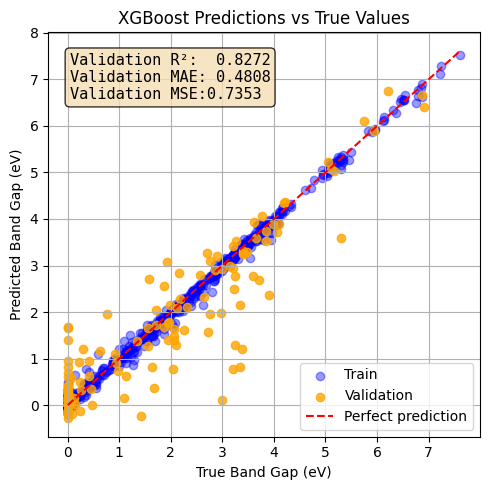

In [10]:
plot_cor(
    Y_train, Y_train_pred,
    Y_val,   Y_val_pred,
    Y_test,  Y_test_pred,
    "XG_BG_23_xgb.png",              
    target_name="bandgap", model_name="XGBoost"
)

In [11]:
results = pd.DataFrame({
    "split": ["Train", "Validation", "Test"],
    "MAE": [
        mean_absolute_error(Y_train, Y_train_pred),
        mean_absolute_error(Y_val,   Y_val_pred),
        mean_absolute_error(Y_test,  Y_test_pred),
    ],
    "RMSE": [
        mean_squared_error(Y_train, Y_train_pred, squared=False),
        mean_squared_error(Y_val,   Y_val_pred,   squared=False),
        mean_squared_error(Y_test,  Y_test_pred,  squared=False),
    ],
    "R2": [
        r2_score(Y_train, Y_train_pred),
        r2_score(Y_val,   Y_val_pred),
        r2_score(Y_test,  Y_test_pred),
    ],
})

print(results.to_string(index=False, float_format="%.3f"))

     split   MAE  RMSE    R2
     Train 0.069 0.106 0.997
Validation 0.481 0.735 0.827
      Test 0.544 0.873 0.800


# Formation Energy

Fold |   R2    |   MAE   |   RMSE
----------------------------------
   1 |  0.841  |   0.096 |   0.198
   2 |  0.619  |   0.127 |   0.345
   3 |  0.881  |   0.099 |   0.165
   4 |  0.682  |   0.102 |   0.318
   5 |  0.894  |   0.080 |   0.147
   6 |  0.810  |   0.096 |   0.232
   7 |  0.719  |   0.138 |   0.299
   8 |  0.865  |   0.095 |   0.177
   9 |  0.766  |   0.112 |   0.231
  10 |  0.877  |   0.090 |   0.169

Averages over 10 folds:
R^2   mean = 0.795, std = 0.090
MAE  mean = 0.103, std = 0.017
RMSE mean = 0.228, std = 0.067

===== Final Model Evaluation =====
Train (FE): MAE=0.006, RMSE=0.009, R^2=1.000
Validation (FE): MAE=0.104, RMSE=0.168, R^2=0.898
Test (FE): MAE=0.121, RMSE=0.266, R^2=0.717
Plot saved to: XG_FE_37_cor.png


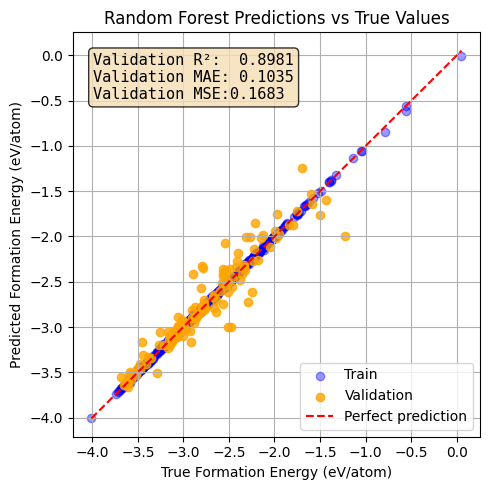

In [111]:
# data check
import pandas as pd
data = pd.read_csv('../processed_data/x_y_formation_normalized.csv')

#data.head()
#data.info()

# split data into features (X) and targets (Y)
X = data.drop(columns=['formation_energy'])
Y = data['formation_energy']

X_trainval, X_test, Y_trainval, Y_test = train_test_split(X, Y, test_size=0.15, random_state=42)

X_train, X_val, Y_train, Y_val = train_test_split(X_trainval, Y_trainval, test_size = 0.15, random_state=42)

kf = KFold(n_splits=10, shuffle=True, random_state=42)

r2s = []
maes = []
rmses = []

print("Fold |   R2    |   MAE   |   RMSE")
print("----------------------------------")

fold = 1

for train_idx, val_idx in kf.split(X):
    X_train_cv = X.iloc[train_idx]
    Y_train_cv = Y.iloc[train_idx]
    X_val_cv = X.iloc[val_idx]
    Y_val_cv = Y.iloc[val_idx]
    
    # Apply same parameters as in part 1:
    
    model_cv = XGBRegressor(
        n_estimators = 300,
        learning_rate = 0.1, 
        gamma = 0,
        max_depth = 6,    
        subsample = 1,   
        colsample_bytree=0.8,
        reg_alpha = 0,
        reg_lambda = 1,

        objective='reg:squarederror',
        random_state=42,
        n_jobs=-1,
    )


    model_cv.fit(X_train_cv, Y_train_cv)
    Y_pred_cv = model_cv.predict(X_val_cv)
    
    r2 = r2_score(Y_val_cv, Y_pred_cv)
    r2s.append(r2)
    mae = mean_absolute_error(Y_val_cv, Y_pred_cv)
    maes.append(mae)
    rmse = mean_squared_error(Y_val_cv, Y_pred_cv, squared=False)
    rmses.append(rmse)
    
    print(f"{fold:>4} | {r2:6.3f}  | {mae:7.3f} | {rmse:7.3f}")
    fold += 1
    
print("\nAverages over 10 folds:")
print(f"R^2   mean = {np.mean(r2s):.3f}, std = {np.std(r2s):.3f}")
print(f"MAE  mean = {np.mean(maes):.3f}, std = {np.std(maes):.3f}")
print(f"RMSE mean = {np.mean(rmses):.3f}, std = {np.std(rmses):.3f}")


model = XGBRegressor(
    n_estimators = 300,
    learning_rate = 0.1, 
    gamma = 0,
    max_depth = 6,    
    subsample = 1,   
    colsample_bytree=0.8,
    reg_alpha = 0,
    reg_lambda = 1,
    
    objective='reg:squarederror',
    random_state=42,
    n_jobs=-1,
)

model.fit(X_train, Y_train)

Y_train_pred = model.predict(X_train)
Y_val_pred   = model.predict(X_val)
Y_test_pred  = model.predict(X_test)

print("\n===== Final Model Evaluation =====")
evaluate("Train", Y_train, Y_train_pred, 'FE')
evaluate("Validation", Y_val, Y_val_pred, 'FE')
evaluate("Test", Y_test, Y_test_pred, 'FE')


plot_cor(
    Y_train, Y_train_pred,
    Y_val,   Y_val_pred,
    Y_test,  Y_test_pred,
    save_path="XG_FE_37_cor.png",
    target_name="formation energy", model_name="Random Forest"
)

## Part 2: Train on 18 features on paper 

In [12]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split, KFold
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from xgboost import XGBRegressor

# 18 features from the paper
paper_features = [
    "B2_ionic_radius",            # R_B'' 
    "A_electronegativity",        # χ_A
    "B1_electronegativity",       # χ_B'
    "B2_electronegativity",       # χ_B''
    "B1_electron_affinity",       # EA_B'
    "B2_electron_affinity",       # EA_B''
    "X_electron_affinity",        # EA_X
    "B1_first_ionization_energy", # IE1_B'
    "X_first_ionization_energy",  # IE1_X
    "A_second_ionization_energy", # IE2_A
    "B1_second_ionization_energy",# IE2_B'
    "A_melting_point",            # Tm_A
    "B1_melting_point",           # Tm_B'
    "B1_thermal_conductivity",    # k_B'
    "A_boiling_point",            # Tb_A
    "B1_boiling_point",           # Tb_B'
    "X_boiling_point",            # Tb_X
    "X_third_ionization_energy",  # IE3_X
]

raw = pd.read_excel("/Users/alisonrhoads/Downloads/supplementary_data_and_dataset_3/data_set_1053.xlsx")

X_raw = raw[paper_features]
Y = raw["formation_energy"]  

scaler = MinMaxScaler()
X = pd.DataFrame(scaler.fit_transform(X_raw), columns=paper_features)

kf = KFold(n_splits=10, shuffle=True, random_state=42)

r2s, maes, rmses = [], [], []

print("Fold |    R2   |   MAE   |   RMSE")
print("-----------------------------------")

for fold, (train_idx, val_idx) in enumerate(kf.split(X), start=1):
    X_train_cv, X_val_cv = X.iloc[train_idx], X.iloc[val_idx]
    Y_train_cv, Y_val_cv = Y.iloc[train_idx], Y.iloc[val_idx]

    model_cv = XGBRegressor(
        n_estimators=300,
        learning_rate=0.1,
        gamma=0,
        max_depth=6,
        subsample=1,
        colsample_bytree=0.8,
        reg_alpha=0,
        reg_lambda=1,
        objective="reg:squarederror",
        random_state=42,
        n_jobs=-1,
    )

    model_cv.fit(X_train_cv, Y_train_cv)
    Y_pred_cv = model_cv.predict(X_val_cv)

    r2   = r2_score(Y_val_cv, Y_pred_cv)
    mae  = mean_absolute_error(Y_val_cv, Y_pred_cv)
    rmse = mean_squared_error(Y_val_cv, Y_pred_cv, squared=False)

    r2s.append(r2)
    maes.append(mae)
    rmses.append(rmse)

    print(f"{fold:4d} | {r2:7.3f} | {mae:7.3f} | {rmse:7.3f}")

print("\nAverages over 10 folds (XGBoost, 18 features):")
print(f"R^2   mean = {np.mean(r2s):.3f}, std = {np.std(r2s):.3f}")
print(f"MAE   mean = {np.mean(maes):.3f}, std = {np.std(maes):.3f}")
print(f"RMSE  mean = {np.mean(rmses):.3f}, std = {np.std(rmses):.3f}")

X_trainval, X_test, Y_trainval, Y_test = train_test_split(
    X, Y, test_size=0.15, random_state=42
)

X_train, X_val, Y_train, Y_val = train_test_split(
    X_trainval, Y_trainval, test_size=0.15, random_state=42
)

# Final XGBoost model
model = XGBRegressor(
    n_estimators=300,
    learning_rate=0.1,
    gamma=0,
    max_depth=6,
    subsample=1,
    colsample_bytree=0.8,
    reg_alpha=0,
    reg_lambda=1,
    objective="reg:squarederror",
    random_state=42,
    n_jobs=-1,
)

model.fit(X_train, Y_train)

Y_train_pred = model.predict(X_train)
Y_val_pred   = model.predict(X_val)
Y_test_pred  = model.predict(X_test)


def evaluate(name, y_true, y_pred, target_name):
    mae  = mean_absolute_error(y_true, y_pred)
    rmse = mean_squared_error(y_true, y_pred, squared=False)
    r2   = r2_score(y_true, y_pred)
    print(f"{name} ({target_name}): MAE={mae:.3f}, RMSE={rmse:.3f}, R^2={r2:.3f}")

print("\n==== XGBoost (18 paper features) – Final Model ====")
evaluate("Train",      Y_train, Y_train_pred, "formationenergy")
evaluate("Validation", Y_val,   Y_val_pred,   "formationenergy")
evaluate("Test",       Y_test,  Y_test_pred,  "formationenergy")


Fold |    R2   |   MAE   |   RMSE
-----------------------------------
   1 |   0.855 |   0.098 |   0.189
   2 |   0.601 |   0.137 |   0.353
   3 |   0.871 |   0.094 |   0.173
   4 |   0.678 |   0.106 |   0.320
   5 |   0.815 |   0.095 |   0.195
   6 |   0.867 |   0.102 |   0.194
   7 |   0.735 |   0.133 |   0.290
   8 |   0.877 |   0.088 |   0.169
   9 |   0.830 |   0.109 |   0.196
  10 |   0.889 |   0.088 |   0.160

Averages over 10 folds (XGBoost, 18 features):
R^2   mean = 0.802, std = 0.093
MAE   mean = 0.105, std = 0.016
RMSE  mean = 0.224, std = 0.066

==== XGBoost (18 paper features) – Final Model ====
Train (formationenergy): MAE=0.012, RMSE=0.023, R^2=0.998
Validation (formationenergy): MAE=0.108, RMSE=0.172, R^2=0.894
Test (formationenergy): MAE=0.121, RMSE=0.264, R^2=0.721


Plot saved to: XG_FE_18_xgb.png


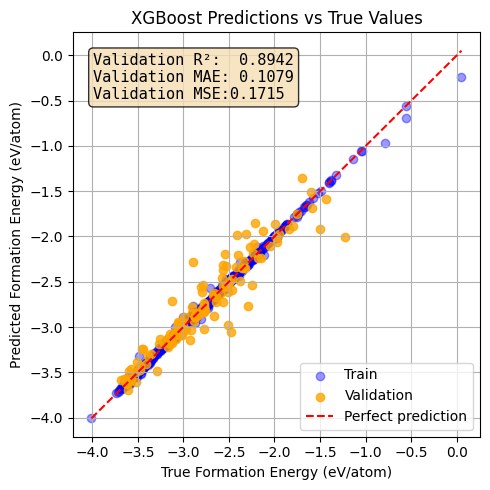

In [13]:
plot_cor(
    Y_train, Y_train_pred,
    Y_val,   Y_val_pred,
    Y_test,  Y_test_pred,
    "XG_FE_18_xgb.png",              
    target_name="formation energy"
)

In [14]:
results = pd.DataFrame({
    "split": ["Train", "Validation", "Test"],
    "MAE": [
        mean_absolute_error(Y_train, Y_train_pred),
        mean_absolute_error(Y_val,   Y_val_pred),
        mean_absolute_error(Y_test,  Y_test_pred),
    ],
    "RMSE": [
        mean_squared_error(Y_train, Y_train_pred, squared=False),
        mean_squared_error(Y_val,   Y_val_pred,   squared=False),
        mean_squared_error(Y_test,  Y_test_pred,  squared=False),
    ],
    "R2": [
        r2_score(Y_train, Y_train_pred),
        r2_score(Y_val,   Y_val_pred),
        r2_score(Y_test,  Y_test_pred),
    ],
})

print(results.to_string(index=False, float_format="%.3f"))

     split   MAE  RMSE    R2
     Train 0.012 0.023 0.998
Validation 0.108 0.172 0.894
      Test 0.121 0.264 0.721
